# La Palma 2021 Erruption data gathering and visualization

## Importing libraries

In [1]:
from datetime import datetime as dt
from datetime import timedelta

import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import contextily as cx
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D

from SeismicPortal.dl_quakes import CANARY_BOX, SeismicPortal

sns.set_theme()
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [30, 15]

## Downloading latest eartquake data for the Canary Islands

In [2]:
sp = SeismicPortal()
# results = sp.download_earthquakes(start_time=dt.now() - timedelta(days=14), **CANARY_BOX)
results = sp.download_earthquakes(start_time=dt.now() - timedelta(days=60), **CANARY_BOX)

1778 earthquakes downloaded.


In [3]:
master_df = pd.DataFrame([q.get("properties") for q in results])

# Tranform data

# Remove timezone info to remove numpy deprecation warning
master_df["time"] = master_df["time"].apply(lambda x: x.strip("Z"))
master_df["lastupdate"] = master_df["lastupdate"].apply(lambda x: x.strip("Z"))

master_df["lastupdate"] = pd.to_datetime(master_df["lastupdate"])
master_df["time"] = pd.to_datetime(master_df["time"])
master_df["date"] = master_df["time"].dt.date

# Enhance data

# Create magnitude bins

m_bins = [
    pd.Interval(left=0, right=2),
    pd.Interval(left=2, right=3),
    pd.Interval(left=3, right=4),
    pd.Interval(left=4, right=5),
    pd.Interval(left=5, right=float("inf"))
]

# m_bins_small = [
#     pd.Interval(left=-float("inf"), right=3),
#     pd.Interval(left=3, right=float("inf")),
# ]

magnitude_ranges = []
for index, row in master_df.iterrows():
    for r in m_bins:
        if row["mag"] in r:
            magnitude_ranges.append(r)

master_df['mag_range'] = magnitude_ranges

# Auto create bins
# master_df['mag_range'] = pd.cut(master_df['mag'], bins = 5)

# Add mean magnitude and depth per day

master_df = pd.merge(master_df, master_df.groupby("date").mean().round(decimals=1)[["mag", "depth"]], on="date", suffixes=("", "_mean"), how="right")

master_df = master_df.sort_values("time", ascending=False, ignore_index=True)
master_df


,lastupdate,magtype,evtype,lon,auth,lat,depth,unid,mag,time,source_id,source_catalog,flynn_region,date,mag_range,mag_mean,depth_mean
0,2021-10-09 17:29:00,ml,ke,-17.85,MDD,28.56,12.0,20211009_0000268,2.4,2021-10-09 17:23:26.500,1046242,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-10-09,"(2, 3]",2.8,14.5
1,2021-10-09 17:30:00,ml,ke,-17.84,MDD,28.56,11.0,20211009_0000269,2.4,2021-10-09 17:20:21.400,1046243,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-10-09,"(2, 3]",2.8,14.5
2,2021-10-09 17:23:00,ml,ke,-17.85,MDD,28.57,11.0,20211009_0000266,2.4,2021-10-09 17:14:31.300,1046240,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-10-09,"(2, 3]",2.8,14.5
3,2021-10-09 17:18:00,ml,ke,-17.83,MDD,28.57,36.0,20211009_0000265,3.0,2021-10-09 17:03:39.900,1046239,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-10-09,"(2, 3]",2.8,14.5
4,2021-10-09 17:08:00,ml,ke,-17.83,MDD,28.55,14.0,20211009_0000261,3.1,2021-10-09 17:01:14.400,1046235,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-10-09,"(3, 4]",2.8,14.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1773,2021-08-12 05:41:00,ml,ke,-16.25,MDD,28.16,22.0,20210812_0000062,1.8,2021-08-12 05:18:56.700,1022382,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-08-12,"(0, 2]",1.6,15.0
1774,2021-08-11 17:44:00,ml,ke,-16.26,MDD,28.13,35.0,20210811_0000155,2.1,2021-08-11 17:37:33.100,1022199,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-08-11,"(2, 3]",1.9,21.0
1775,2021-08-11 07:05:00,ml,ke,-17.85,MDD,29.53,10.0,20210811_0000060,2.6,2021-08-11 06:42:25.400,1022071,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-08-11,"(2, 3]",1.9,21.0
1776,2021-08-11 07:13:00,ml,ke,-16.30,MDD,27.98,24.0,20210811_0000062,1.5,2021-08-11 06:25:15.700,1022075,EMSC-RTS,"CANARY ISLANDS, SPAIN REGION",2021-08-11,"(0, 2]",1.9,21.0


## Visualization of data

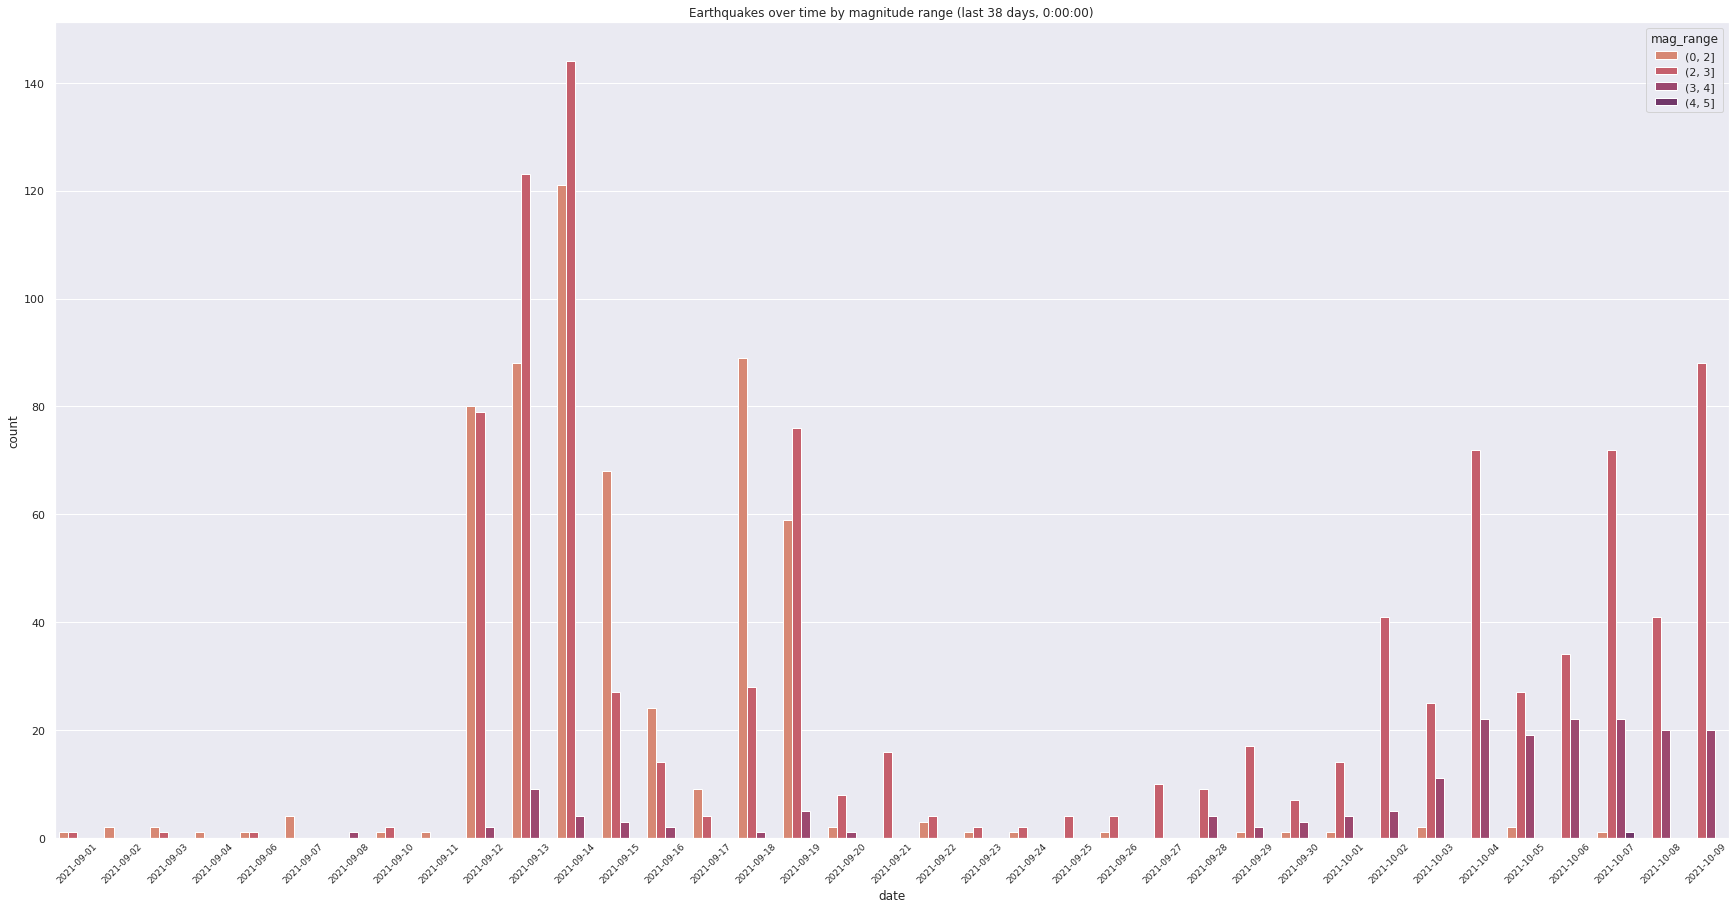

In [4]:
fig = plt.figure()

def eq_over_time_by_mag(fig, r=1, c=1, ix=1):

    df = master_df[master_df["time"] >= dt(2021, 9, 1)]
    
    ax = fig.add_subplot(r,c,ix)
    ax.tick_params(axis='x', rotation=45, labelsize=9, direction="in")

    ax.set_title(f"Earthquakes over time by magnitude range (last {df.iloc[0].date - df.iloc[-1].date})")
    sns.countplot(data=df.sort_values("date"), x="date", palette="flare", hue="mag_range", hue_order=df["mag_range"].sort_values().unique(), dodge=True);

eq_over_time_by_mag(fig);

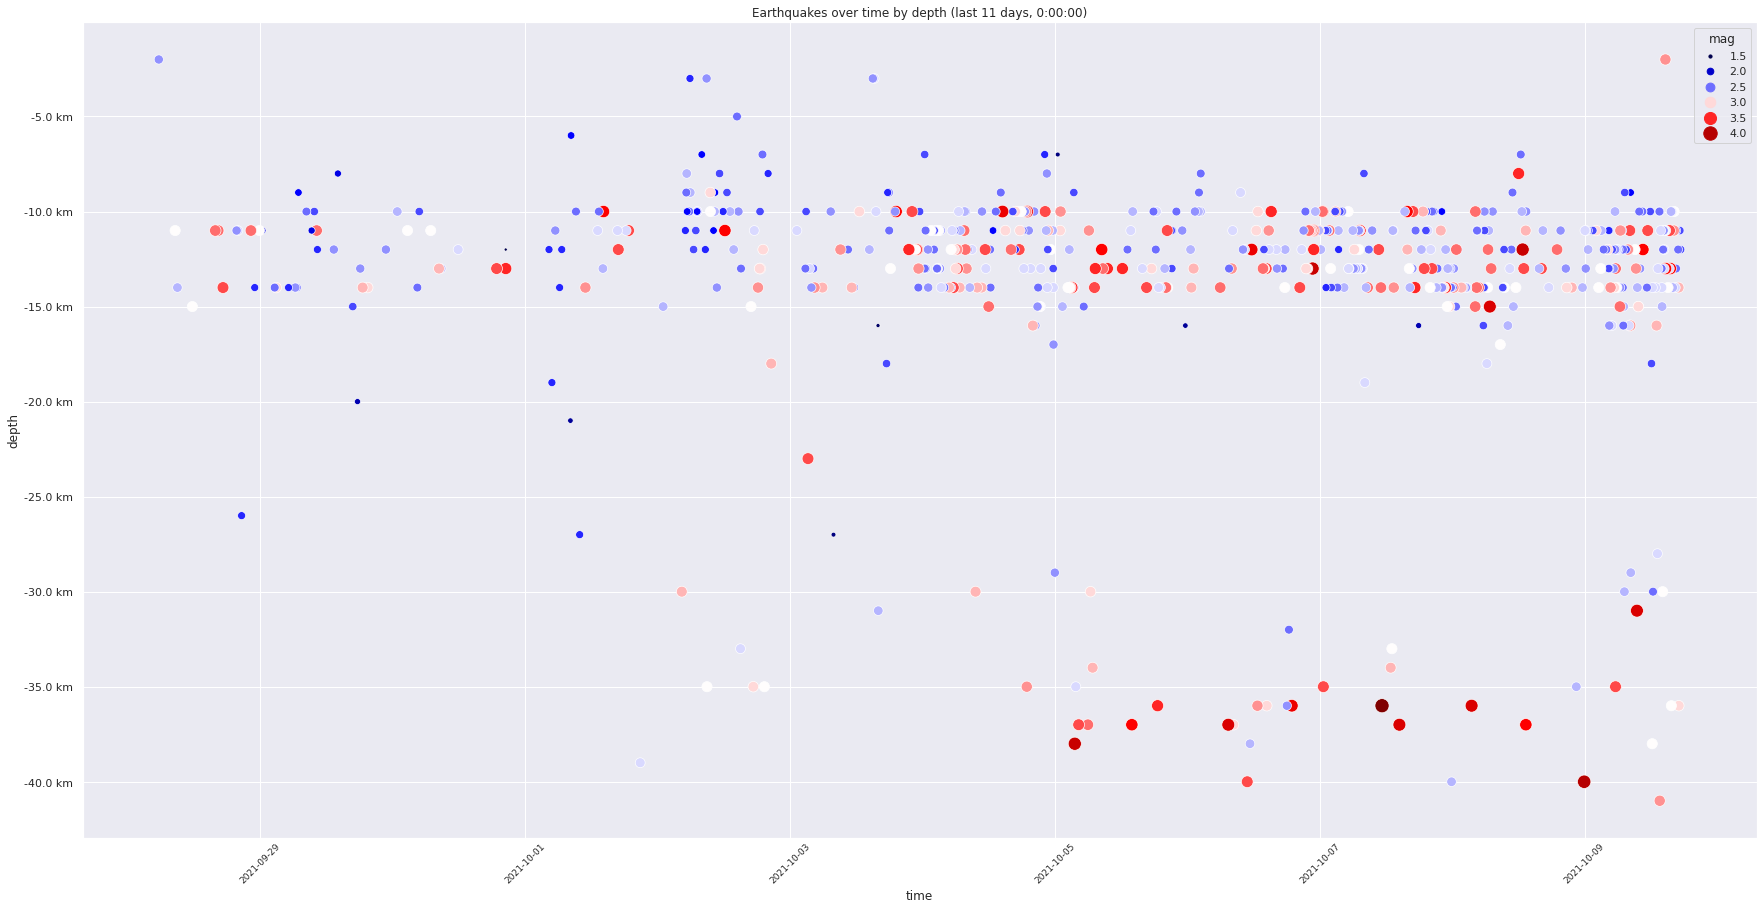

In [5]:
fig = plt.figure()

def eq_over_time_by_depth(fig, r=1, c=1, ix=1):
    
    df = master_df[master_df["time"] >= dt(2021, 9, 28)]
    
    ax = fig.add_subplot(r,c,ix)
    ax.set_title(f"Earthquakes over time by depth (last {df.iloc[0].date - df.iloc[-1].date})")
    ax.tick_params(axis='x', rotation=45, labelsize=9, direction="in")
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f km'))

    sns.scatterplot(data=df, x="time", y=-df["depth"], hue="mag", size="mag", sizes=(10, 200), palette="seismic")
    
eq_over_time_by_depth(fig);

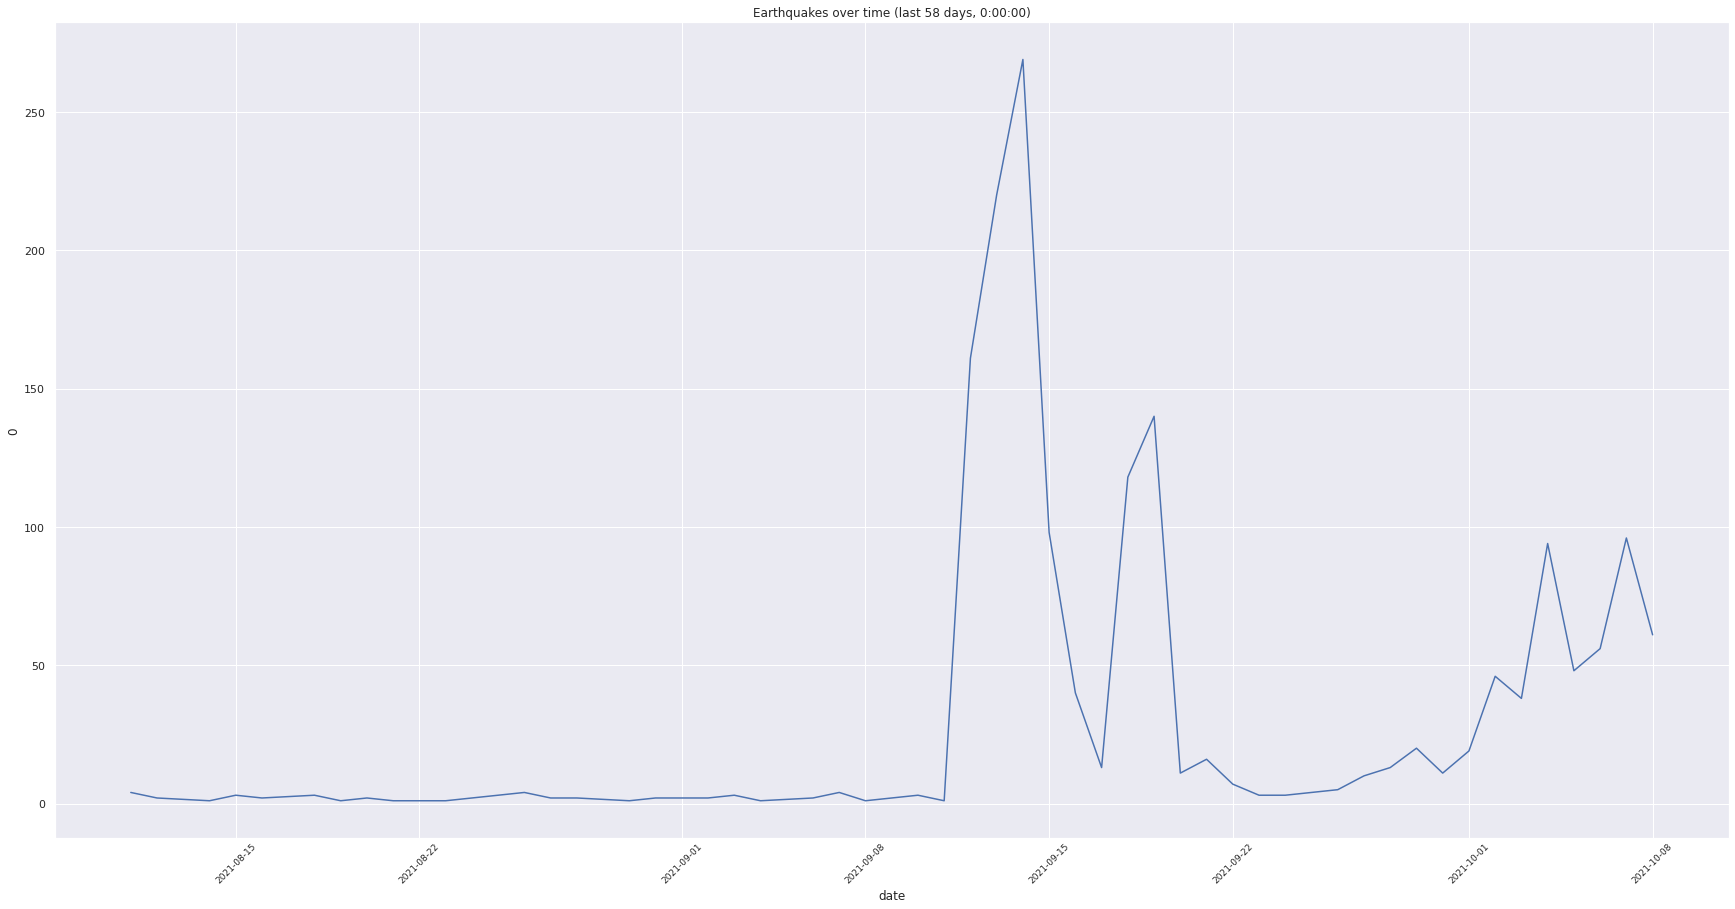

In [6]:
fig = plt.figure()

def eq_daily_count(fig, r=1, c=1, ix=1):
    
    df = master_df[master_df["date"] < master_df.iloc[0].date]
    
    ax = fig.add_subplot(r,c,ix)
    ax.tick_params(axis='x', rotation=45, labelsize=9, direction="in")

    ax.set_title(f"Earthquakes over time (last {df.iloc[0].date - df.iloc[-1].date})")

    sns.lineplot(data=df.groupby("date").size().reset_index(), x="date", y=df.groupby("date").size().reset_index()[0])
    
eq_daily_count(fig)

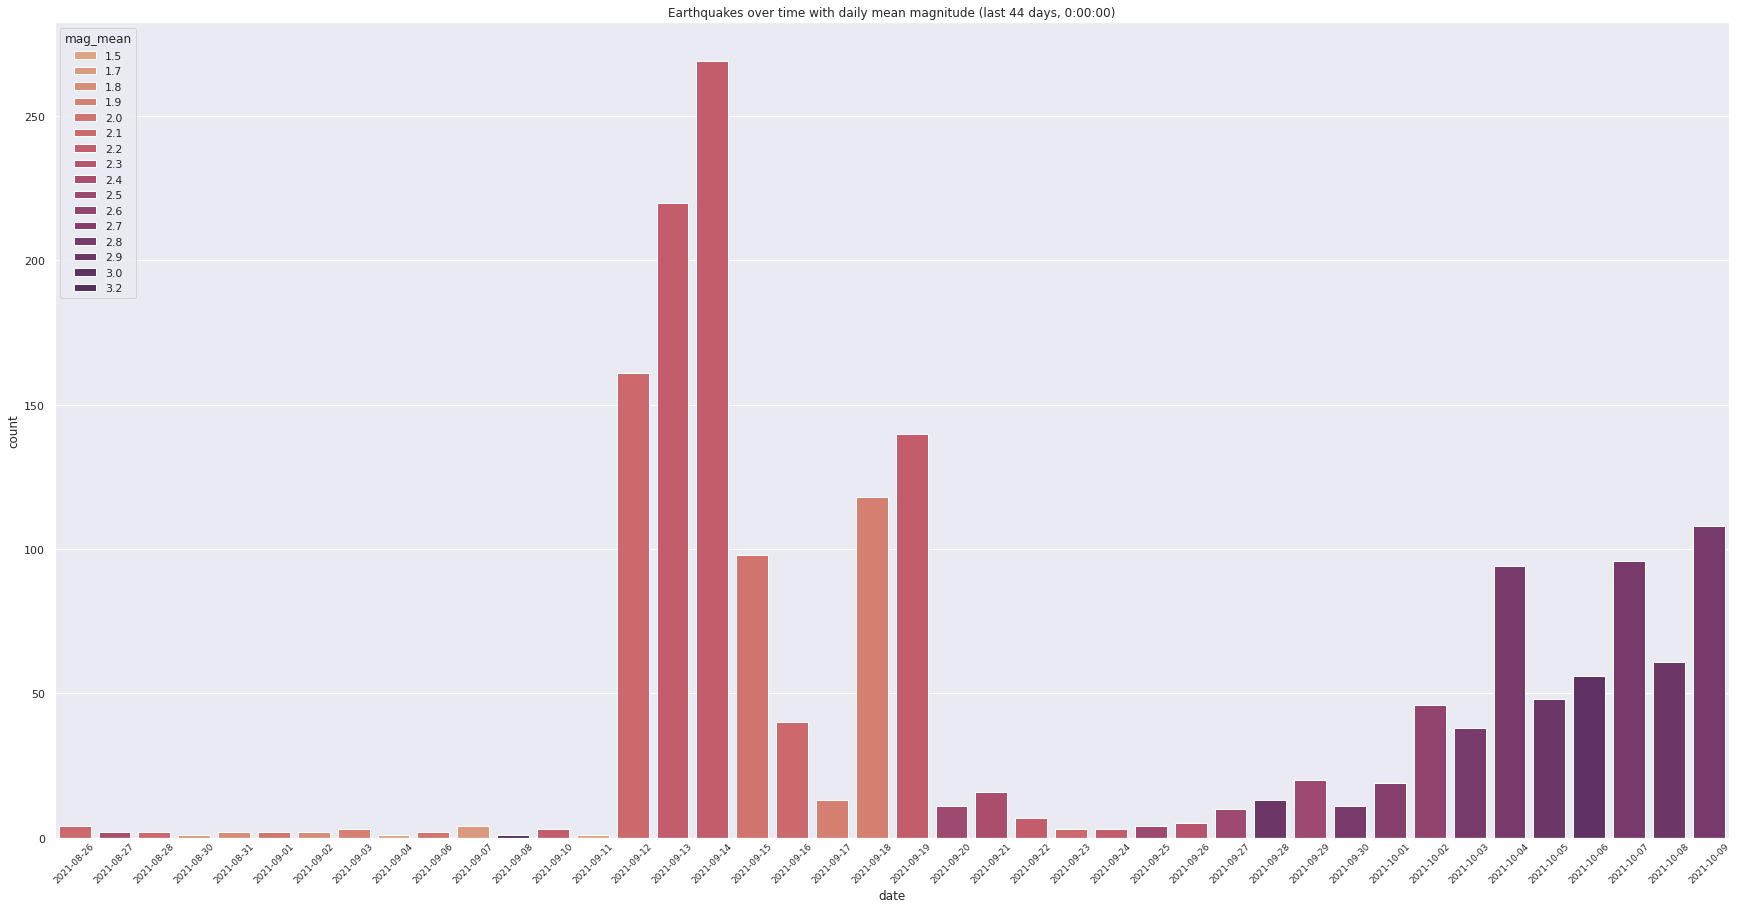

In [7]:
fig = plt.figure()

def eq_count_mean_mag_over_time(fig, r=1, c=1, ix=1):
    
    df = master_df[master_df["time"] >= dt.now() - timedelta(days=45)]

    ax = fig.add_subplot(r,c,ix)
    ax.tick_params(axis='x', rotation=45, labelsize=9, direction="in")
    ax.set_title(f"Earthquakes over time with daily mean magnitude (last {df.iloc[0].date - df.iloc[-1].date})")

    sns.countplot(data=df.sort_values("date"), x="date", palette="flare", hue="mag_mean", dodge=False)
    sns.move_legend(ax, loc="upper left")
    
eq_count_mean_mag_over_time(fig)

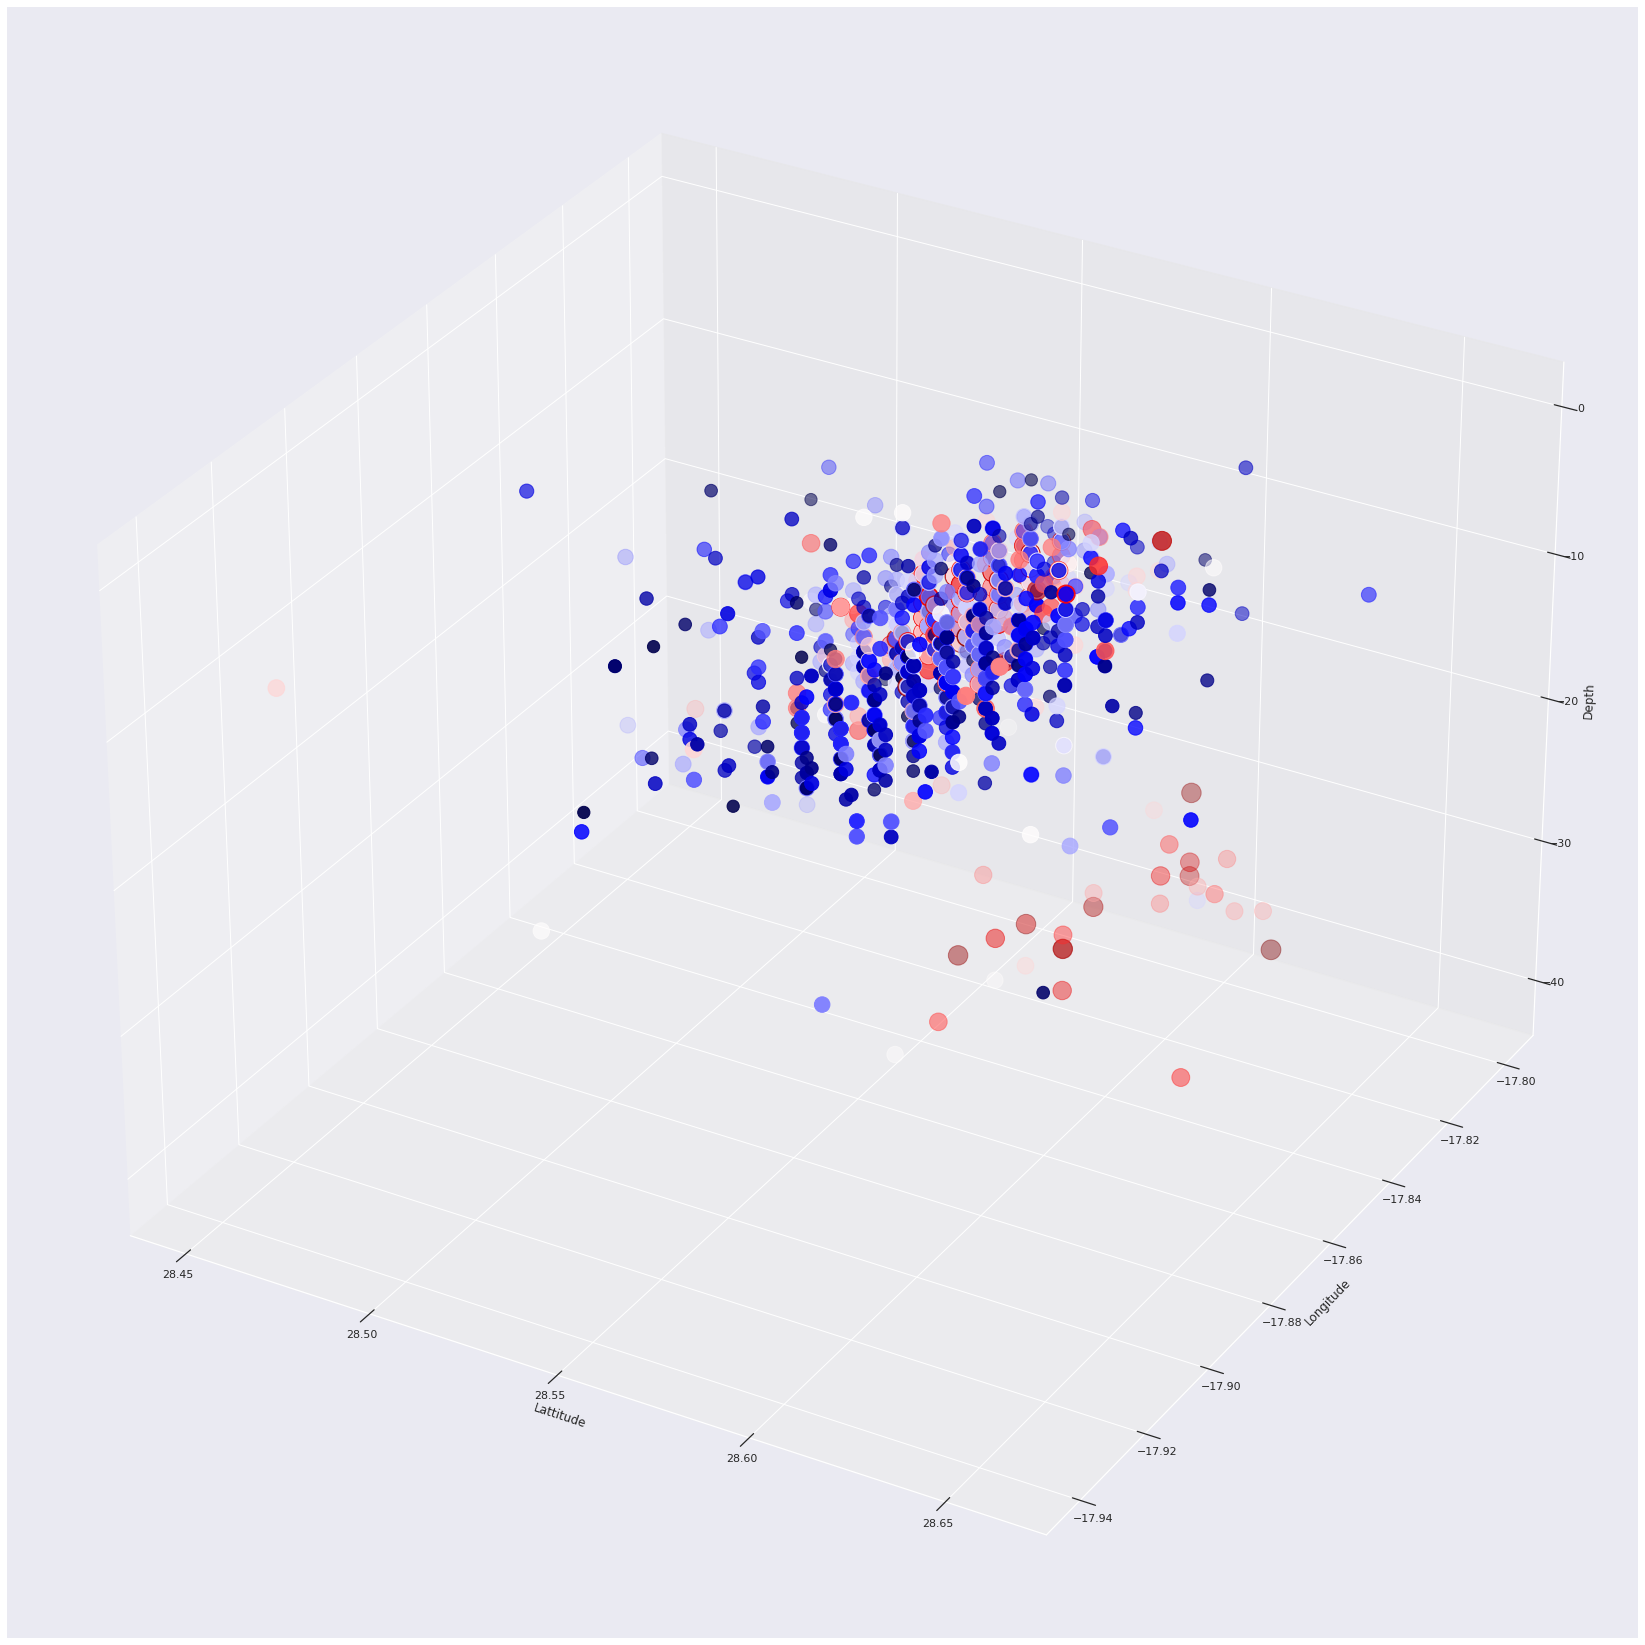

In [8]:
fig = plt.figure(figsize=[30, 30])

def eq_depth_3d(fig, r=1, c=1, ix=1):
    
    ax = fig.add_subplot(r,c,ix, projection = '3d')

    df = master_df[(master_df.lat <= 28.961) & (master_df.lat >= 28.324) & (master_df.lon <= -17.7935) & (master_df.lon >= -17.9478)]

    x = df['lat']
    y = df['lon']
    z = -df['depth']

    ax.set_xlabel("Lattitude")
    ax.set_ylabel("Longitude")
    ax.set_zlabel("Depth")

    ax.scatter(x, y, z, c=df['mag'], cmap="seismic", s=df["mag"] * 100, depthshade=True)

eq_depth_3d(fig)

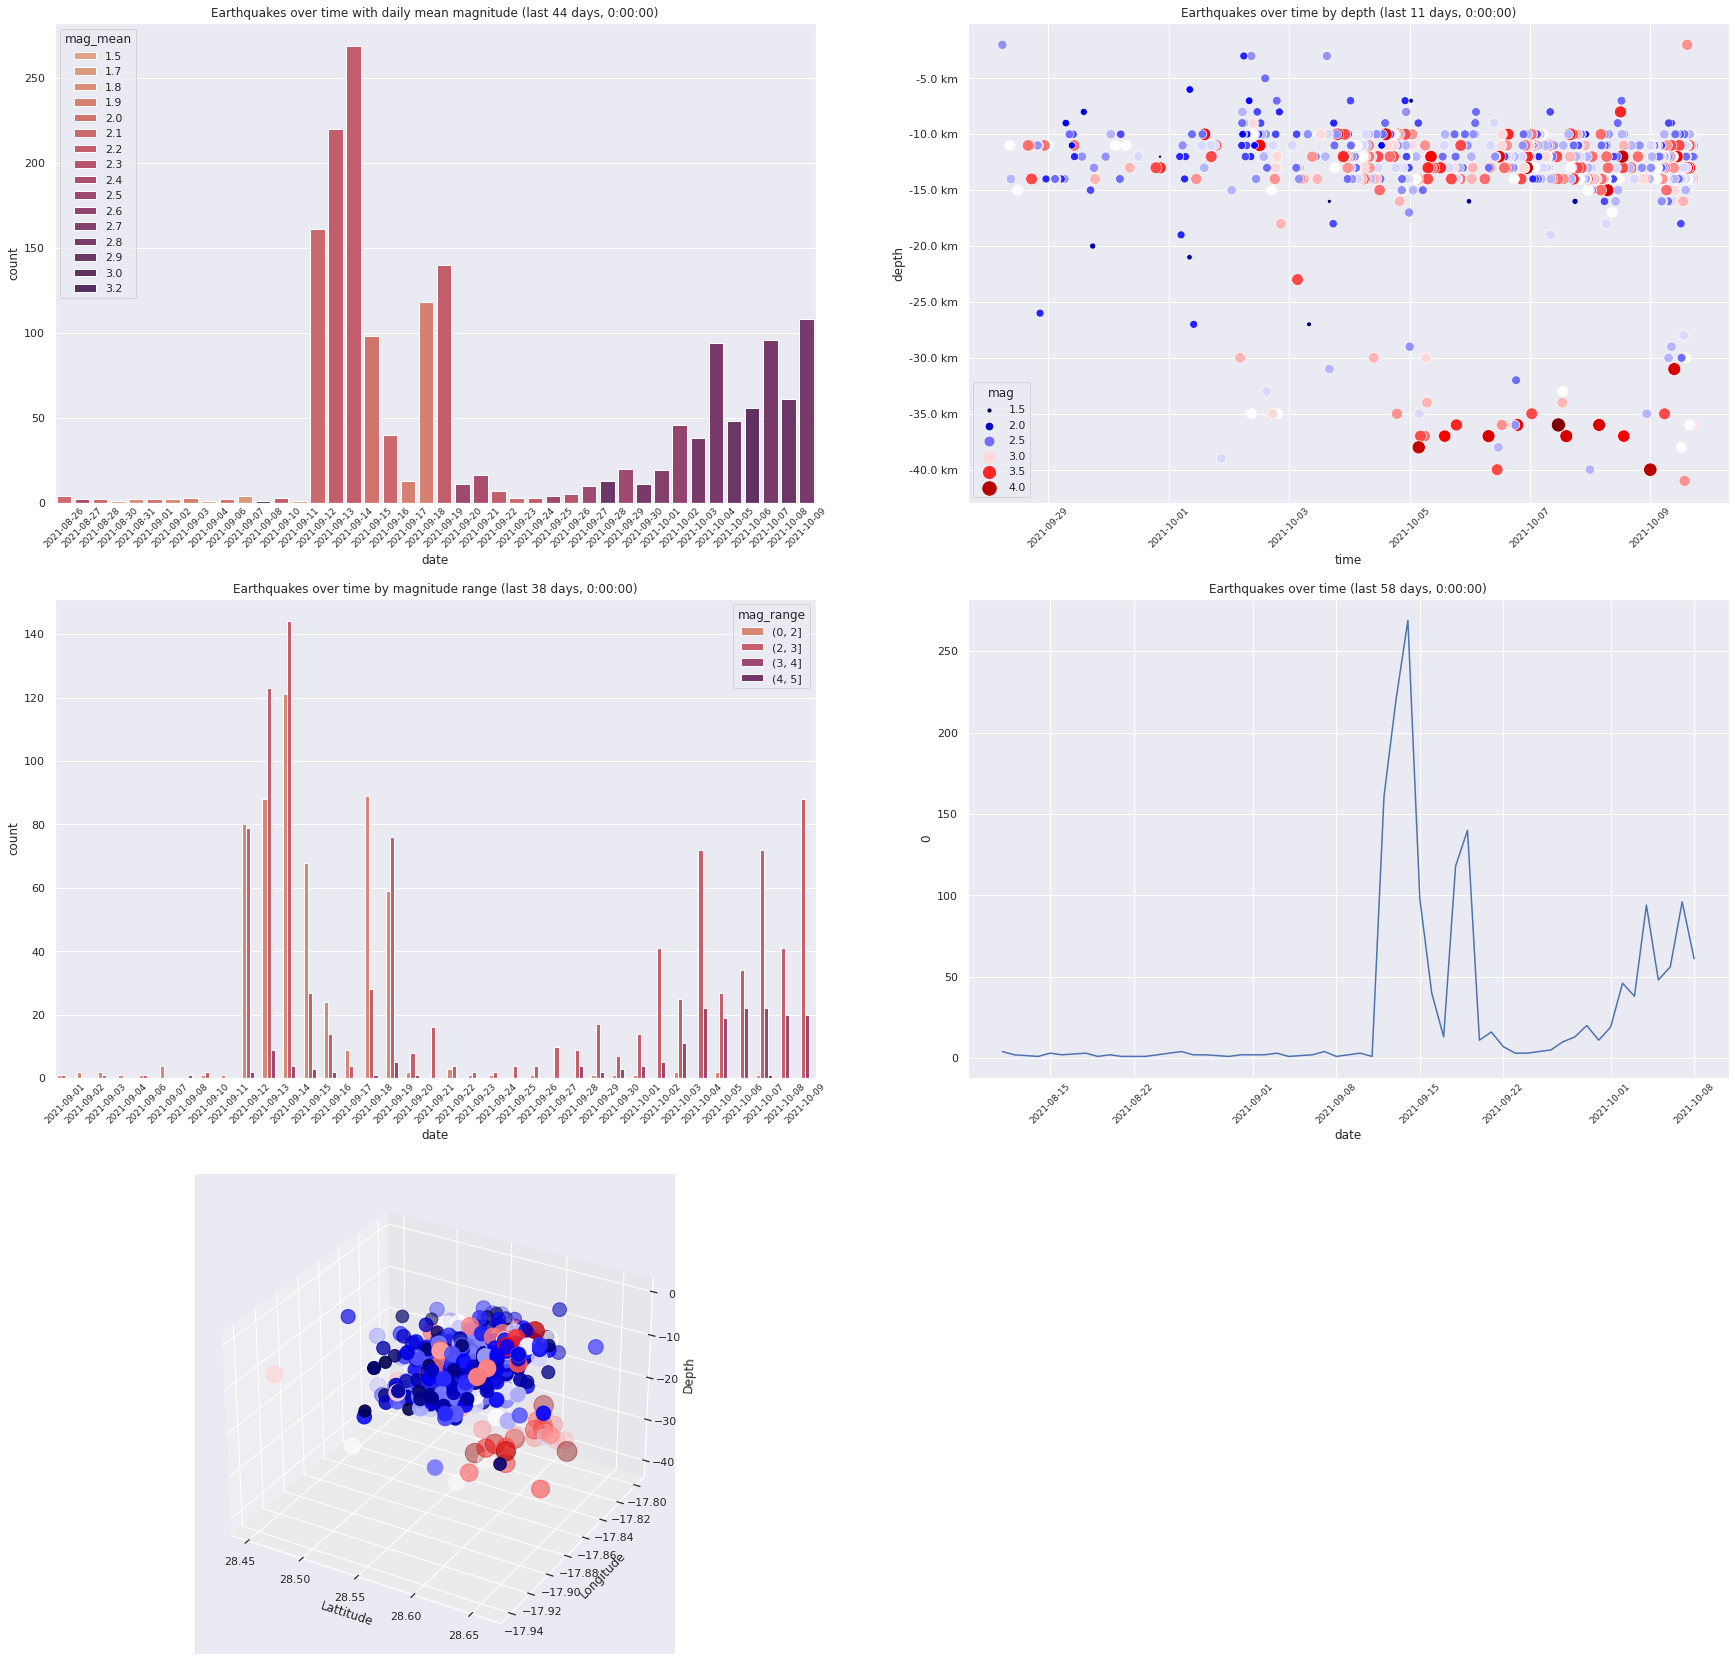

In [9]:
fig = plt.figure(figsize=[30, 30])

eq_count_mean_mag_over_time(fig, 3, 2, 1) 
eq_over_time_by_depth(fig, 3, 2, 2)
eq_over_time_by_mag(fig, 3, 2, 3)
eq_daily_count(fig, 3, 2, 4)
eq_depth_3d(fig, 3, 2, 5)

In [10]:
print(f"This notebook was last updated: {dt.utcnow()} UTC")

This notebook was last updated: 2021-10-09 17:34:02.055364 UTC


## Donation

If you find this  useful please consider donating to one of my crypto account. Thank you :)

[![Donate](https://img.shields.io/badge/Donate-BTC-green.svg?style=plastic&logo=bitcoin)](https://raw.githubusercontent.com/Anonymous5726221/lapalma_data/master/Donate/BTC_Bitcoin)
[![Donate](https://img.shields.io/badge/Donate-BNB-green.svg?style=plastic&logo=binance)](https://raw.githubusercontent.com/Anonymous5726221/lapalma_data/master/Donate/BNB_BinanceSmartChain)
[![Donate](https://img.shields.io/badge/Donate-FTM-green.svg?style=plastic&logo=data:image/svg%2bxml;base64,PHN2ZyBjbGlwLXJ1bGU9ImV2ZW5vZGQiIGZpbGwtcnVsZT0iZXZlbm9kZCIgc3Ryb2tlLWxpbmVqb2luPSJyb3VuZCIgc3Ryb2tlLW1pdGVybGltaXQ9IjIiIHZpZXdCb3g9IjAgMCA1NjAgNDAwIiB4bWxucz0iaHR0cDovL3d3dy53My5vcmcvMjAwMC9zdmciPjxjaXJjbGUgY3g9IjI4MCIgY3k9IjIwMCIgZmlsbD0iIzEzYjVlYyIgcj0iMTUwIiBzdHJva2Utd2lkdGg9IjkuMzc1Ii8+PHBhdGggZD0ibTE3LjIgMTIuOSAzLjYtMi4xdjQuMnptMy42IDktNC44IDIuOC00LjgtMi44di00LjlsNC44IDIuOCA0LjgtMi44em0tOS42LTExLjEgMy42IDIuMS0zLjYgMi4xem01LjQgMy4xIDMuNiAyLjEtMy42IDIuMXptLTEuMiA0LjItMy42LTIuMSAzLjYtMi4xem00LjgtOC4zLTQuMiAyLjQtNC4yLTIuNCA0LjItMi41em0tMTAuMi0uNHYxMy4xbDYgMy40IDYtMy40di0xMy4xbC02LTMuNHoiIGZpbGw9IiNmZmYiIHRyYW5zZm9ybT0ibWF0cml4KDkuMzc1IDAgMCA5LjM3NSAxMzAgNTApIi8+PC9zdmc+)](https://raw.githubusercontent.com/Anonymous5726221/lapalma_data/master/Donate/FTM_Fantom)